In [1]:
import h5py
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
nside = 2**7
NPIX = hp.nside2npix(nside)
print("nside =", nside)
print("NPIX =", NPIX)

nside = 128
NPIX = 196608


<KeysViewHDF5 ['data', 'smooth_absorb', 'spectral_index']>
data shape = (196608,)
data type = <class 'h5py._hl.dataset.Dataset'>


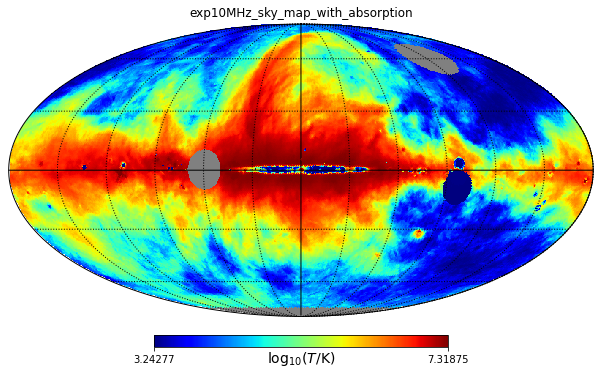

In [3]:
# open data file
with h5py.File('exp10MHz_sky_map_with_absorption.hdf5', 'r') as f:
    data = f['data']
    print(f.keys())
    print('data shape =', data.shape)
    print('data type =', type(data))
    
    # define the vectors of three pointings
    vec_polar = hp.ang2vec(np.pi, 0) # theta = pi, phi = 0
    vec_galactic = hp.ang2vec(np.pi/2, np.pi/3)
    vec_quiet = hp.ang2vec(np.pi/6, -np.pi*2/3)
    
    # find the indices of all the pixels within 10 degrees of these pointings
    ipix_disc_polar = hp.query_disc(nside=nside, vec=vec_polar, radius=np.radians(10))
    ipix_disc_galactic = hp.query_disc(nside=nside, vec=vec_galactic, radius=np.radians(10))
    ipix_disc_quiet = hp.query_disc(nside=nside, vec=vec_quiet, radius=np.radians(10))
    
    # define the mask
    mask = np.zeros(NPIX, dtype=bool)
    mask[ipix_disc_polar] = 1
    mask[ipix_disc_galactic] = 1
    mask[ipix_disc_quiet] = 1
    
    # mask the data
    data_masked = hp.ma(data)
    data_masked.mask = mask
    
    # plot and save the mollview of the masked data
    hp.mollview(
    np.log10(data_masked),
    cmap=plt.cm.jet,
    title="exp10MHz_sky_map_with_absorption",
    unit=r"$\log_{10}(T/\mathrm{K})$",
    norm='hist')
    hp.graticule()
    plt.savefig("10MHz_all_sky_map.jpg", dpi=100)
    
    # if the figure is plotted correctly, find data for each of the three region
    data_polar = data[ipix_disc_polar]
    data_galactic = data[ipix_disc_galactic]
    data_quiet = data[ipix_disc_quiet]
    # find the theta and phi for these pixels
    theta_polar, phi_polar = np.degrees(hp.pix2ang(nside=nside, ipix=ipix_disc_polar))
    theta_galactic, phi_galactic = np.degrees(hp.pix2ang(nside=nside, ipix=ipix_disc_galactic))
    theta_quiet, phi_quiet = np.degrees(hp.pix2ang(nside=nside, ipix=ipix_disc_quiet))

In [4]:
# combine data to 3D
polar = np.vstack((data_polar, theta_polar, phi_polar))
galactic = np.vstack((data_galactic, theta_galactic, phi_galactic))
quiet = np.vstack((data_quiet, theta_quiet, phi_quiet))

# transfer numpy.array to .fits
hdu_polar = fits.PrimaryHDU(polar)
hdu_galactic = fits.PrimaryHDU(galactic)
hdu_quiet = fits.PrimaryHDU(quiet)
hdu_polar.writeto("10MHz_polar.fits", overwrite=True)
hdu_galactic.writeto("10MHz_galactic.fits", overwrite=True)
hdu_quiet.writeto("10MHz_quiet.fits", overwrite=True)

/tmp/ipykernel_315/1838856086.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


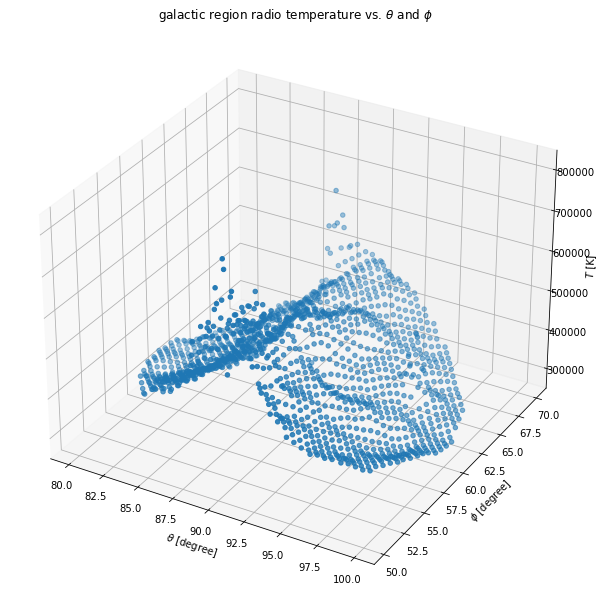

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits

with fits.open("10MHz_galactic.fits") as hdul:
    T, theta, phi = hdul[0].data

fig = plt.figure(figsize=(16,8))
ax = Axes3D(fig)
ax.scatter(theta, phi, T)
ax.set_xlabel(r"$\theta$ [degree]")
ax.set_ylabel("$\phi$ [degree]")
ax.set_zlabel("$T$ [K]")
ax.set_title(r"galactic region radio temperature vs. $\theta$ and $\phi$")
plt.savefig("10MHz_T_theta_phi_galactic.jpg")